## Perguntas

1) Carregar e ler arquivos .csv, xlsx ou de um banco de dados;
2) Avaliar a necessidade da transformação da variável em outra escala (agrupar idade por faixas, por exemplo);
3) Realizar a codificação das variáveis categóricas de acordo com os valores das variáveis (label encoder, one hot encoder ou target encoder);
4) Normalizar as variáveis;
5) Avaliar a necessidade de realizar o balanceamento da variável alvo;
6) Tratar variáveis com alta correlação;
7) Realizar a seleção de variáveis;
8) Aplicar um modelo de regressão ou classificação utilizando uma técnica de hiperparametrização automática;
9) Aplicar uma medida de avaliação do modelo.
10) Gerar uma visualização para o resultado de acordo com os tipos abaixo:
    - Agrupamento: gerar a visualização Scatter;
    - Classificação: gerar a matriz de confusão; 
    - Regressão: gerar a visualização da linha de saída.

### Leitura dos dados

In [1]:
# Somente rodar se necessário
# Descomente a linha a baixo para rodar!
# %pip install locale
# %pip install googletrans==4.0.0-rc1

In [2]:
#IMPORT E INSTALL AS BIBLIOTECAS IMPORTANTES
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from googletrans import Translator # Precisa do pacote do pip install
import locale # Precisa do pacoote do pip install
from matplotlib.ticker import FuncFormatter

In [3]:
caminho = 'Data/Bike-day.csv'
df = pd.read_csv(caminho)

### Tratamento dos dados

#### Tradução 

In [4]:
def traduzir_colunas(df, language='pt'):
    #Dicionario para as palavras que não foram traduzidas ou que foram traduzidas erroneamente 
    erro_ao_traduzir = {
        'dteday': 'Data',
        'mnth': 'Mês',
        'weathersit': 'Clima',
        'temp': 'Temperatura',
        'hum': 'Umidade',
        'windspeed': 'Velocidade do Vento',
        'registered': 'Registrados',
        'cnt': 'Total_Bikes',
        'atemp': 'Sensação térmica'
    }
    
    # Renomear as colunas
    traducoes = {}
    tradutor = Translator()
    for coluna in df.columns:
        try:
            if coluna in erro_ao_traduzir:
                traducoes[coluna] = erro_ao_traduzir[coluna] # Utilize a tradução personalizada
            else:
                traduzido = tradutor.translate(coluna, src='en', dest=language) # Tradução acontece aqui
                if traduzido and traduzido.text:
                    capslock = traduzido.text.capitalize() # Maiúscula na primeira letra de cada palavra

                    traducoes[coluna] = capslock
                else:
                    print(f"Erro ao traduzir a coluna '{coluna}': tradução retornou None ou texto vazio")
                    traducoes[coluna] = coluna # Manter o nome original em caso de erro
        except Exception as a:
            print(f"Erro ao traduzir a coluna '{coluna}': {a}")
            traducoes[coluna] = coluna # Manter o nome original em caso de erro

    df.columns = [traducoes.get(col, col) for col in df.columns]

In [5]:
#EXECUTA A FUNÇÃO DE TRADUÇÃO
df_traduzido = df.copy()
traduzir_colunas(df_traduzido)
df_traduzido.head(5)

,Instante,Data,Temporada,Ano,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura,Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Total_Bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
#REMOVE O INDEXADOR DA PLANILHA
df_traduzido = df_traduzido.drop(columns=['Instante'])
df_traduzido.head(5)

,Data,Temporada,Ano,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura,Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Total_Bikes
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
#RENOMEANDO OS VALORES NUMERICOS PARA ESTAÇÕES DO ANO (season : season (1:winter, 2:spring, 3:summer, 4:fall)) e Ano  (yr : year (0: 2011, 1:2012))

if 'Temporada' in df_traduzido.columns:
        df_traduzido['Temporada'] = df_traduzido['Temporada'].replace({1: 'Inverno', 2: 'Primavera', 3: 'Verão', 4: 'Outono'})

if 'Ano' in df_traduzido.columns:
        df_traduzido['Ano'] = df_traduzido['Ano'].replace({0: '2011', 1: '2012'})
df_traduzido.head(5)

,Data,Temporada,Ano,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura,Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Total_Bikes
0,2011-01-01,Inverno,2011,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,Inverno,2011,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,Inverno,2011,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,Inverno,2011,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,Inverno,2011,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


#### Informações gerais do dataset

In [8]:
df_traduzido.describe()

,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura,Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Total_Bikes
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [9]:
df_traduzido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data                 731 non-null    object 
 1   Temporada            731 non-null    object 
 2   Ano                  731 non-null    object 
 3   Mês                  731 non-null    int64  
 4   Feriado              731 non-null    int64  
 5   Dia da semana        731 non-null    int64  
 6   Dia de trabalho      731 non-null    int64  
 7   Clima                731 non-null    int64  
 8   Temperatura          731 non-null    float64
 9   Sensação térmica     731 non-null    float64
 10  Umidade              731 non-null    float64
 11  Velocidade do Vento  731 non-null    float64
 12  Casual               731 non-null    int64  
 13  Registrados          731 non-null    int64  
 14  Total_Bikes          731 non-null    int64  
dtypes: float64(4), int64(8), object(3)
memor

### Análise Descritiva dos dados

Gerar tabelas sobre o data set: (gráfico de barras, colunas, linha, etc)

- relação mês x aluguel - guzinho
- relação temperatura x aluguel - guzinho

- concorrência de casual x registrado - vitinho
- Qual é o impacto dos dias úteis e feriados no uso de bicicletas? - vitinho

#### Relação season x aluguel - Allan

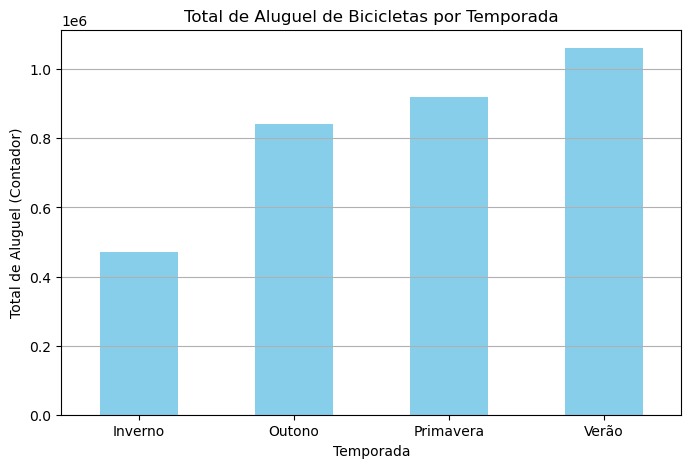

In [10]:
# Gerando o gráfico de análise descritiva
contador_temporada_X_Aluguel = df_traduzido.groupby('Temporada')['Total_Bikes'].sum()

plt.figure(figsize=(8, 5))
contador_temporada_X_Aluguel.plot(kind='bar', color='skyblue')
plt.title('Total de Aluguel de Bicicletas por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Total de Aluguel (Contador)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Mostrar o gráfico
plt.show()

In [11]:
# Identificar as top temporadas com o maior número de aluguéis
top_temporadas = contador_temporada_X_Aluguel.sort_values(ascending=False).head(4)
for i, (temporada, total) in enumerate(top_temporadas.items(), start=1):
    print(f'Top {i}: {temporada} com {total} aluguéis')

Top 1: Verão com 1061129 aluguéis
Top 2: Primavera com 918589 aluguéis
Top 3: Outono com 841613 aluguéis
Top 4: Inverno com 471348 aluguéis


# Relação Mês x Aluguel - Gustavo

In [12]:
def format_func(value, tick_number):
    return locale.format_string('%.0f', value, grouping=True)

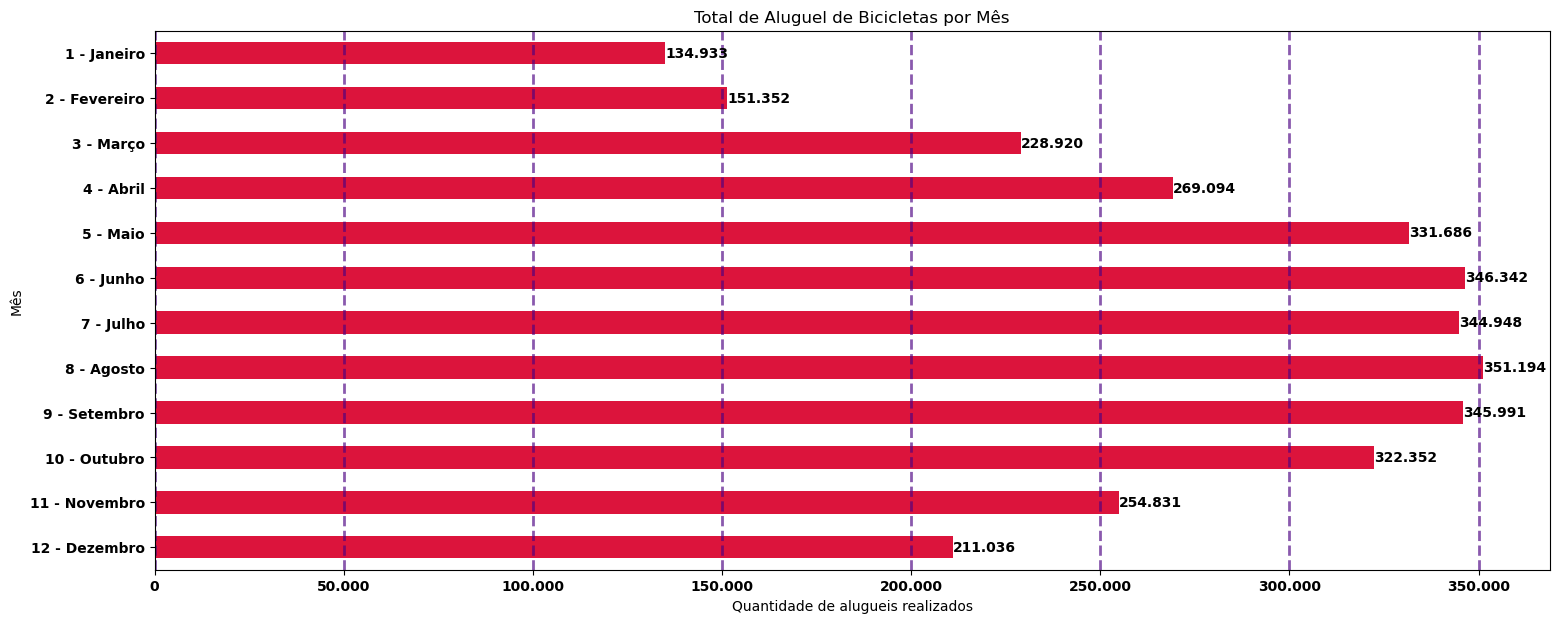

Mês
1     134933
2     151352
3     228920
4     269094
5     331686
6     346342
7     344948
8     351194
9     345991
10    322352
11    254831
12    211036
Name: Total_Bikes, dtype: int64

In [85]:
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
formatter = FuncFormatter(format_func)

BikesPorMes = df_traduzido.groupby('Mês')['Total_Bikes'].sum()
months_dict = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
y_labels = [f'{month_num} - {months_dict[month_num]}' for month_num in BikesPorMes.index]


plt.figure(figsize=(18, 7))
BikesPorMes.plot(kind='barh', color='#DC143C')
plt.title('Total de Aluguel de Bicicletas por Mês')
plt.xlabel('Quantidade de alugueis realizados')
plt.ylabel('Mês')
plt.xticks(rotation=0)
plt.grid(axis='x', color='#4B0082', linestyle='dashed', linewidth=2, alpha=0.65)
plt.gca().invert_yaxis()
plt.yticks(ticks=range(len(BikesPorMes)), labels=y_labels, weight='bold')
plt.gca().xaxis.set_major_formatter(formatter)


for tick in plt.gca().get_xticklabels():
    tick.set_weight('bold')

for index, value in enumerate(BikesPorMes):
    plt.text(value, index, locale.format_string('%.0f', value, grouping=True), color='black', va='center', weight='bold')

plt.show()

# Relação Temperatura x Aluguel - Gustavo

In [98]:
bikes = df_traduzido.groupby('Mês')['Total_Bikes'].sum()
TemperaturaPorMes = df_traduzido.groupby('Mês')['Temperatura'].mean()
BikesTemperaturaMensal = pd.merge(TemperaturaPorMes, bikes, on='Mês', how='left')
# BikesTemperaturaMensal = BikesTemperaturaMensal.drop(columns=['Mês'])
# BikesTemperaturaMensal
BikesTemperaturaMensal

,Temperatura,Total_Bikes
Mês,,
1,0.236444,134933
2,0.299226,151352
3,0.390539,228920
4,0.469999,269094
5,0.594798,331686
6,0.684097,346342
7,0.755470,344948
8,0.708582,351194
9,0.616485,345991


In [59]:
months_dict = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
y_labels = [f'{month_num} - {months_dict[month_num]}' for month_num in BikesTemperaturaMensal.index]


plt.figure(figsize=(18, 7))
BikesTemperaturaMensal.plot(kind='barh', color='#DC143C')
plt.title('Total de Aluguel de Bicicletas por Mês')
plt.xlabel('Quantidade de alugueis realizados')
plt.ylabel('Mês')
plt.xticks(rotation=0)
plt.grid(axis='x', color='#4B0082', linestyle='dashed', linewidth=2, alpha=0.65)
plt.gca().invert_yaxis()
plt.yticks(ticks=range(len(BikesTemperaturaMensal)), labels=y_labels, weight='bold')
plt.gca().xaxis.set_major_formatter(formatter)


for tick in plt.gca().get_xticklabels():
    tick.set_weight('bold')

for index, value in enumerate(BikesTemperaturaMensal):
    plt.text(value, index, locale.format_string('%.0f', value, grouping=True), color='black', va='center', weight='bold')

plt.show()

KeyError: 0

### Análise de correlação de variáveis

In [16]:
df_corr = df_traduzido
df_corr['Temporada'] = df_corr['Temporada'].replace({'Inverno': 1, 'Primavera': 2, 'Verão': 3, 'Outono': 4})

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_1272\3367099422.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_corr.corr(), annot = True)


<Axes: >

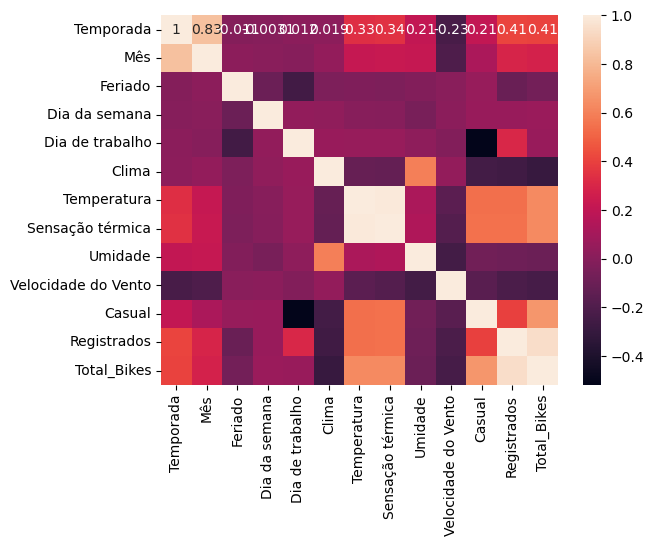

In [17]:
sns.heatmap(df_corr.corr(), annot = True)

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_1272\3755665838.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_corr.corr(method= 'spearman'), annot = True)


<Axes: >

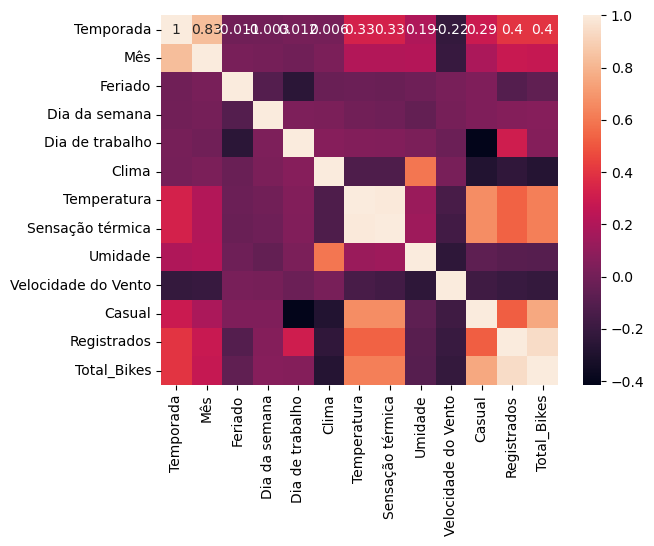

In [18]:
sns.heatmap(df_corr.corr(method= 'spearman'), annot = True)

In [19]:
# Criação da matriz de ppscore de todo o dataset
matrix_pps = pps.matrix(df_corr)
matrix_pps

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Data,Data,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,Data,Temporada,0.000000,feature_is_id,True,None,0.000000,0.000000,None
2,Data,Ano,0.000000,feature_is_id,True,None,0.000000,0.000000,None
3,Data,Mês,0.000000,feature_is_id,True,None,0.000000,0.000000,None
4,Data,Feriado,0.000000,feature_is_id,True,None,0.000000,0.000000,None
...,...,...,...,...,...,...,...,...,...
220,Total_Bikes,Umidade,0.000000,regression,True,mean absolute error,0.116434,0.153643,DecisionTreeRegressor()
221,Total_Bikes,Velocidade do Vento,0.000000,regression,True,mean absolute error,0.060702,0.080512,DecisionTreeRegressor()
222,Total_Bikes,Casual,0.074592,regression,True,mean absolute error,506.383037,468.610697,DecisionTreeRegressor()
223,Total_Bikes,Registrados,0.628836,regression,True,mean absolute error,1263.709986,469.044020,DecisionTreeRegressor()


In [20]:
# Filtrar apenas as relações com a variável alvo
pps_alvo = matrix_pps[matrix_pps['y'] == 'Total_Bikes']
pps_alvo

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
14,Data,Total_Bikes,0.000000,feature_is_id,True,None,0.000000,0.000000,None
29,Temporada,Total_Bikes,0.178853,regression,True,mean absolute error,1581.454172,1298.606520,DecisionTreeRegressor()
44,Ano,Total_Bikes,0.155137,regression,True,mean absolute error,1581.454172,1336.112154,DecisionTreeRegressor()
59,Mês,Total_Bikes,0.163606,regression,True,mean absolute error,1581.454172,1322.718057,DecisionTreeRegressor()
74,Feriado,Total_Bikes,0.001195,regression,True,mean absolute error,1581.454172,1579.564616,DecisionTreeRegressor()
89,Dia da semana,Total_Bikes,0.000000,regression,True,mean absolute error,1581.454172,1600.977581,DecisionTreeRegressor()
104,Dia de trabalho,Total_Bikes,0.000000,regression,True,mean absolute error,1581.454172,1582.873775,DecisionTreeRegressor()
119,Clima,Total_Bikes,0.056168,regression,True,mean absolute error,1581.454172,1492.627276,DecisionTreeRegressor()
134,Temperatura,Total_Bikes,0.044871,regression,True,mean absolute error,1581.454172,1510.492162,DecisionTreeRegressor()
149,Sensação térmica,Total_Bikes,0.010464,regression,True,mean absolute error,1581.454172,1564.906324,DecisionTreeRegressor()


In [21]:
# Varáveis que possuem valor maior que 0.05 em relação ao Total_Bikes
selected_variables = pps_alvo[pps_alvo['ppscore'] > 0.05]['x'].tolist()
selected_variables

['Temporada', 'Ano', 'Mês', 'Clima', 'Casual', 'Registrados', 'Total_Bikes']

### Modelos de Regressão Linear

- Regressão linear - murilo
- Lasso - murilo
- Elastic Net
- Regressão Ridge

#### Bibliotecas dos modelos e de avaliações

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Tratamento dos dados e separação de treino e teste

In [23]:
df_modelos = df_traduzido.drop(columns=['Data','Ano'])

In [24]:
df_modelos['Temporada'] = df_traduzido['Temporada'].replace({'Inverno': 1, 'Primavera': 2, 'Verão': 3, 'Outono': 4})

In [25]:
# Separação dos dados de treino e testes
X = df_modelos.drop(columns = 'Total_Bikes')
y = df_modelos['Total_Bikes']
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=.2, random_state=42)

#### Regressão linear

#### Lasso

#### Elastic Net

In [26]:
# Grid de parâmetros para o modelo
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.2, 0.4, 0.5, 0.6, 0.8]
}

In [27]:
# Montagem do modelo
modelo_elastic = GridSearchCV(ElasticNet(),
                                param_grid,
                                scoring= 'accuracy',
                                n_jobs = -1)

In [28]:
# Fit com os dados de treino
modelo_elastic.fit(X_treino, y_treino)

c:\Users\Gustavo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'l1_ratio': [0.2, 0.4, 0.5, 0.6, 0.8]},
             scoring='accuracy')

In [29]:
# Verificação dos melhores parâmetros do grid
modelo_elastic.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.2)

##### Validação do modelo

Matriz de confusão e Score de acurácia

In [30]:
# Regressão
y_predito_EN = modelo_elastic.predict(X_teste)

In [31]:
# Calcular MSE
mse = mean_squared_error(y_teste, y_predito_EN)
print(f'Erro quadrático médio: {mse}')

Erro quadrático médio: 1.4683596968653836e-07


In [32]:
# Calcular MAE
mae = mean_absolute_error(y_teste, y_predito_EN)
print(f'Erro absoluto médio: {mae}')

Erro absoluto médio: 0.000293591522784371


In [33]:
# Calcular R²
r2 = r2_score(y_teste, y_predito_EN)
print(f'R²: {r2}')

R²: 0.9999999999999634


#### Regressão Ridge

In [34]:
# Grid de parâmetros para o modelo
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['svd','cholesky','lsqr', 'sparse_cg', 'sag', 'saga']
}

In [35]:
# Montagem do modelo
modelo_ridge = GridSearchCV(Ridge(),
                                param_grid,
                                scoring= 'accuracy',
                                n_jobs = -1)

In [36]:
# Fit com os dados de treino
modelo_ridge.fit(X_treino, y_treino)

c:\Users\Gustavo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring='accuracy')

In [37]:
# Verificação dos melhores parâmetros do grid
modelo_ridge.best_estimator_

Ridge(alpha=0.1, solver='svd')

##### Validação do modelo

Matriz de confusão e Score de acurácia

In [38]:
# Regressão
y_predito_Ridge = modelo_elastic.predict(X_teste)

In [39]:
# Calcular MSE
mse = mean_squared_error(y_teste, y_predito_Ridge)
print(f'Erro quadrático médio: {mse}')

Erro quadrático médio: 1.4683596968653836e-07


In [40]:
# Calcular MAE
mae = mean_absolute_error(y_teste, y_predito_Ridge)
print(f'Erro absoluto médio: {mae}')

Erro absoluto médio: 0.000293591522784371


In [41]:
# Calcular R²
r2 = r2_score(y_teste, y_predito_Ridge)
print(f'R²: {r2}')

R²: 0.9999999999999634


##### Impacto das Condições Climáticas (Clima, Temperatura, Umidade, Velocidade do Vento) - Vitinho

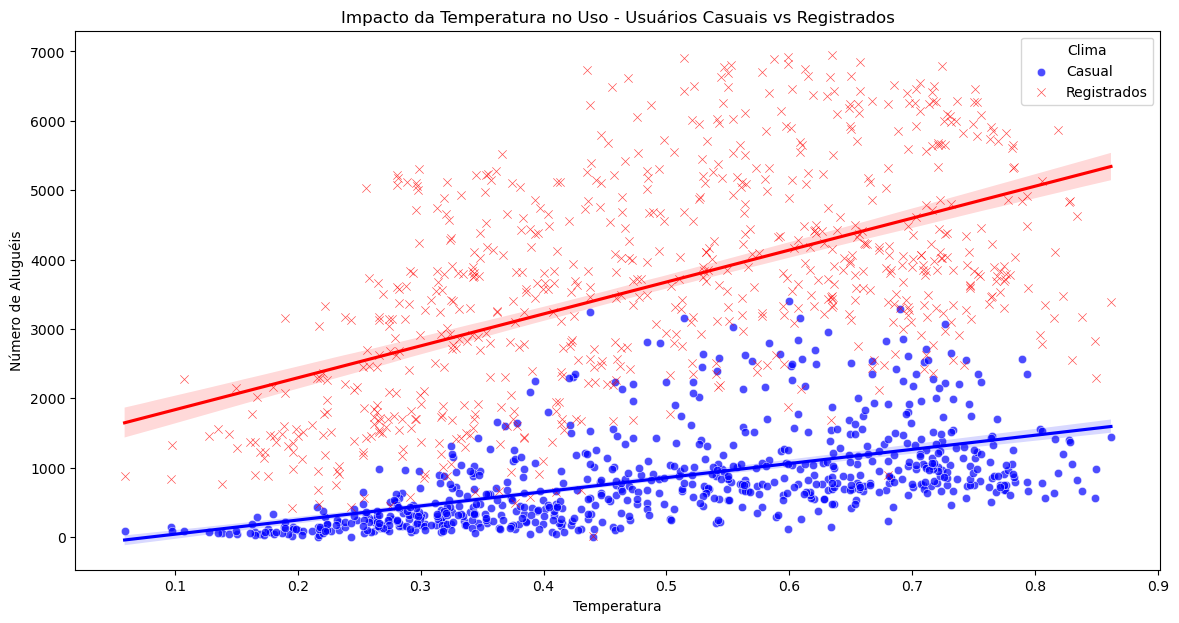

In [53]:
# Impacto da Temperatura no Uso
# Plotar o gráfico de dispersão com regressão e intervalo de confiança
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_traduzido, x='Temperatura', y='Casual', alpha=0.7, label='Casual', color='blue')
sns.scatterplot(data=df_traduzido, x='Temperatura', y='Registrados', alpha=0.7, marker='x', label='Registrados', color='red')
sns.regplot(data=df_traduzido, x='Temperatura', y='Casual', scatter=False, color='blue', ci=95)
sns.regplot(data=df_traduzido, x='Temperatura', y='Registrados', scatter=False, color='red', ci=95)
plt.title('Impacto da Temperatura no Uso - Usuários Casuais vs Registrados')
plt.xlabel('Temperatura')
plt.ylabel('Número de Aluguéis')
plt.legend(title='Clima')
plt.show()


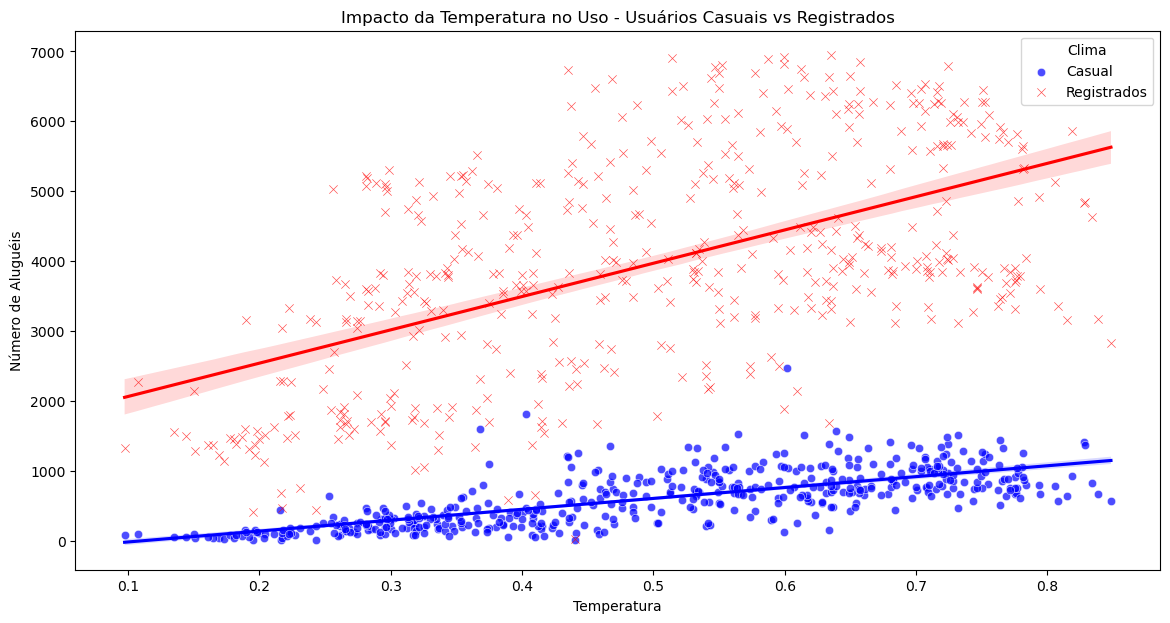

In [60]:
# Impacto da Temperatura no Uso
# Plotar o gráfico de dispersão com regressão e intervalo de confiança
# Em dias de trabalho

df_traduzido_sem_feriado = df_traduzido[df_traduzido ['Dia de trabalho'] != 0]
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_traduzido_sem_feriado, x='Temperatura', y='Casual', alpha=0.7, label='Casual', color='blue')
sns.scatterplot(data=df_traduzido_sem_feriado, x='Temperatura', y='Registrados', alpha=0.7, marker='x', label='Registrados', color='red')
sns.regplot(data=df_traduzido_sem_feriado, x='Temperatura', y='Casual', scatter=False, color='blue', ci=95)
sns.regplot(data=df_traduzido_sem_feriado, x='Temperatura', y='Registrados', scatter=False, color='red', ci=95)
plt.title('Impacto da Temperatura no Uso - Usuários Casuais vs Registrados')
plt.xlabel('Temperatura')
plt.ylabel('Número de Aluguéis')
plt.legend(title='Clima')
plt.show()

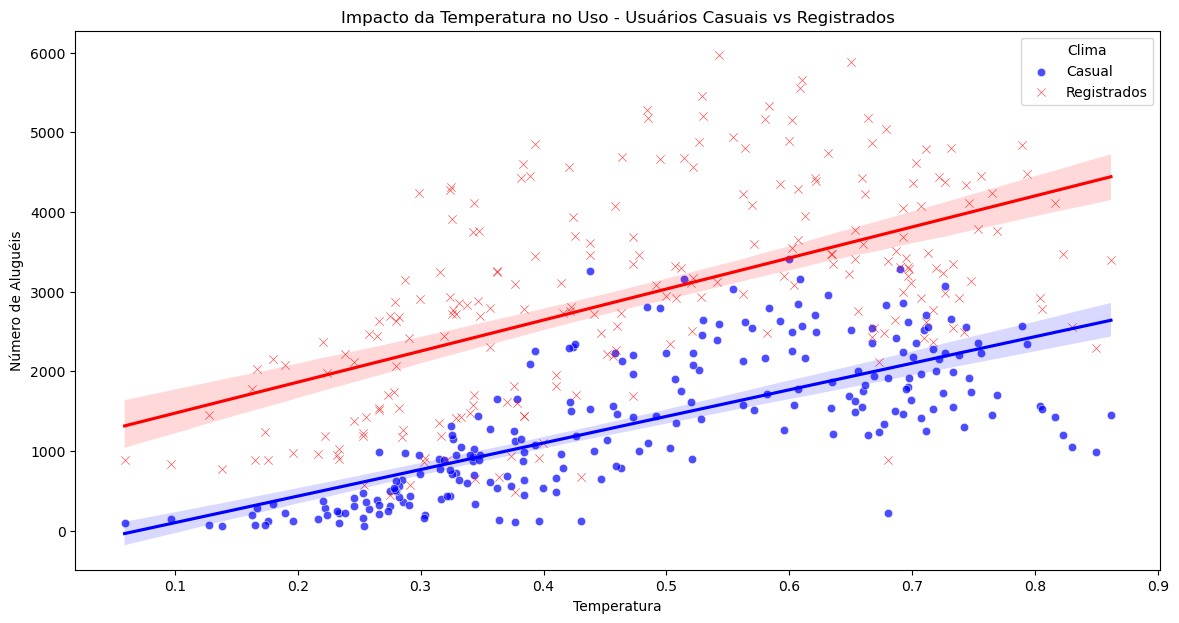

In [61]:
# Impacto da Temperatura no Uso
# Plotar o gráfico de dispersão com regressão e intervalo de confiança
#Em feriados e fins de semana
df_traduzido_com_feriado = df_traduzido[df_traduzido ['Dia de trabalho'] == 0]
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_traduzido_com_feriado, x='Temperatura', y='Casual', alpha=0.7, label='Casual', color='blue')
sns.scatterplot(data=df_traduzido_com_feriado, x='Temperatura', y='Registrados', alpha=0.7, marker='x', label='Registrados', color='red')
sns.regplot(data=df_traduzido_com_feriado, x='Temperatura', y='Casual', scatter=False, color='blue', ci=95)
sns.regplot(data=df_traduzido_com_feriado, x='Temperatura', y='Registrados', scatter=False, color='red', ci=95)
plt.title('Impacto da Temperatura no Uso - Usuários Casuais vs Registrados')
plt.xlabel('Temperatura')
plt.ylabel('Número de Aluguéis')
plt.legend(title='Clima')
plt.show()

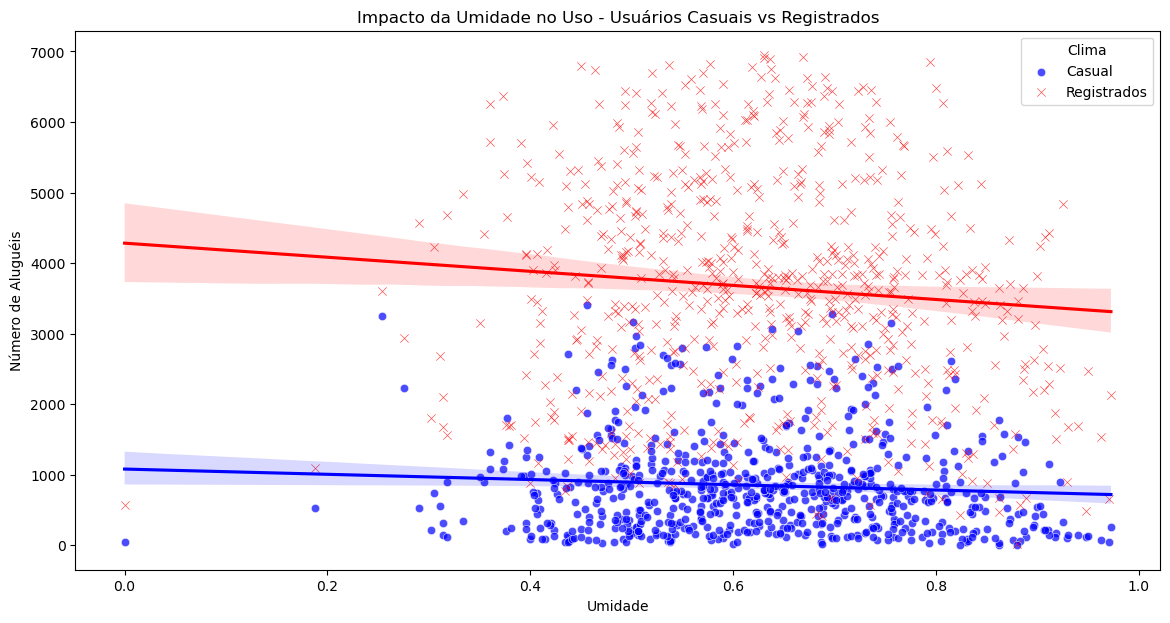

In [62]:

# Impacto da Umidade no Uso
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_traduzido, x='Umidade', y='Casual', color='blue', alpha=0.7, label='Casual')
sns.scatterplot(data=df_traduzido, x='Umidade', y='Registrados',color='red', alpha=0.7, marker='x', label='Registrados')
sns.regplot(data=df_traduzido, x='Umidade', y='Casual', scatter=False, color='blue', ci=95)
sns.regplot(data=df_traduzido, x='Umidade', y='Registrados', scatter=False, color='red', ci=95)
plt.title('Impacto da Umidade no Uso - Usuários Casuais vs Registrados')
plt.xlabel('Umidade')
plt.ylabel('Número de Aluguéis')
plt.legend(title='Clima')
plt.show()

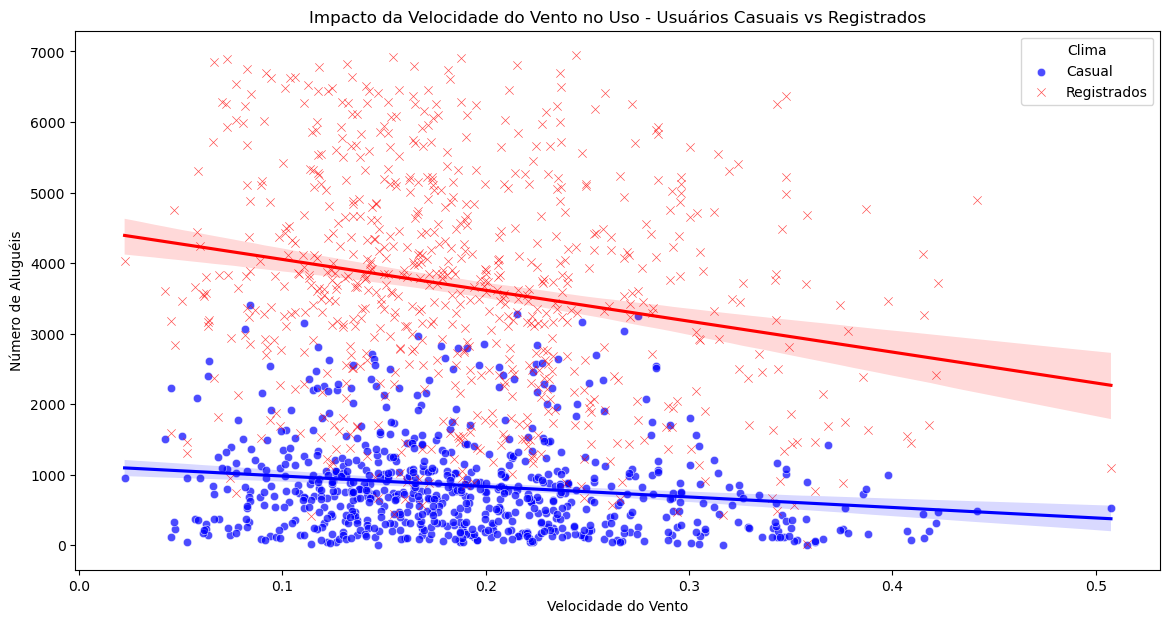

In [63]:
# Impacto da Velocidade do Vento no Uso
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_traduzido, x='Velocidade do Vento', y='Casual', color='blue', alpha=0.7, label='Casual')
sns.scatterplot(data=df_traduzido, x='Velocidade do Vento', y='Registrados',color='red', alpha=0.7, marker='x', label='Registrados')
sns.regplot(data=df_traduzido, x='Velocidade do Vento', y='Casual', scatter=False, color='blue', ci=95)
sns.regplot(data=df_traduzido, x='Velocidade do Vento', y='Registrados', scatter=False, color='red', ci=95)
plt.title('Impacto da Velocidade do Vento no Uso - Usuários Casuais vs Registrados')
plt.xlabel('Velocidade do Vento')
plt.ylabel('Número de Aluguéis')
plt.legend(title='Clima')
plt.show()